# Tuning CNNs

**Objective**

- Describe the main components of a CNN

### CNN Architecture

Let's review our guidelines for building CNNs: Generally, CNNs are created with layers that follow a specific pattern:
- The input layer (the image size/input_shape of the first layer) should be divisible by 2 many times (e.g., 32, 64, 96, 224, 384, 512)
    - Adjust your image size as needed based on your local machine's performance
    - Note: Transfer-Learning models generally require at least 96x96 to use their top layers.
- 1-2 Convolutional layers together, followed by a Pooling layer
    - Pattern usually repeated 2-3 times before final layers
        - **How many times?** - We will work on determining
    - Conv2D layers should use:
        - A small filter size (3x3, 5x5 at most)
        - Stride of 1
        - Padding = 'same' (don't want to change image size)
        - **How many filters?**
    - Pooling layers should use:
        - pool_size=2 (no larger than 3)
        - stride=2
    - A flattening layer
    - Optional: Depending on the complexity of the task, there may be one or more hidden Dense layers.
    - Final layer needs to be a Dense layer with the correct number of units for the task (1 per each class if multiclassification, single neuron if a regression task).

In this less, we will demonstrate hypertuning a CNN model with a Cats and Dogs dataset.

### Imports, Functions

In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

import os

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [2]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [3]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [4]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [5]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

### Preparing the Image Dataset from the Directory

For this lesson, we will be working with the Cats & Dogs dataset from Kaggle: https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs

In [6]:
# Checking the contents of dataset folder (YOUR PATH MAY BE DIFFERENT!)
data_dir = "Data/CatsvDogs/dataset/"
data_dir

'Data/CatsvDogs/dataset/'

In [7]:
# Getting the list of folders in the data_dir
os.listdir(data_dir)

['single_prediction', 'test_set', 'training_set']

In [8]:
# Getting list of all img file paths (ONLY, did not make recursive so no folders were included)
img_files = glob.glob(data_dir+"**/**/*")#, recursive=True)
len(img_files)

10000

We will be using the tensorflow `image_dataset_from_directory` function again. Unlike the chest xrays dataset, these files have already been split into a training_set folder and a test_set folder.

We will need to split the data again to create our validation split.

In [9]:
# Getting the # of images in the training_set folder
train_folder = data_dir+"training_set/"
print(train_folder)
len(glob.glob(train_folder + "**/*"))

Data/CatsvDogs/dataset/training_set/


8000

In [10]:
test_folder = data_dir+"test_set/"
print(test_folder)
len(glob.glob(test_folder + "**/*"))

Data/CatsvDogs/dataset/test_set/


2000

We have 8000 training images and 2000 test images. We will use all 8,000 training_set images as the training data, but we will split the test_set into 50% for validation during training and 50% for final testing.

### Making the image_dataset_from_directory

Note: Depending on your local machine's RAM, you may be able to use a larger image size. However, tuning the model will become much more taxing on your computer.

In [11]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 64
img_width = 64

In [12]:
# make the dataset from the main folder of images
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    shuffle=True,
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 8000 files belonging to 2 classes.


For the test data, we want to split images from the same directory into two groups (one for validation and one for testing). We can do this with image_dataset_from_directory by adding the following:
- the subset argument ( we want "both").
- the validation_split argument. (validation_split=.5)

In [13]:
# make the dataset from the main folder of images
test_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    validation_split=.5,
    subset='both',
    shuffle=True,
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1000 files for training.
Using 1000 files for validation.


Note that print statements are "built-in" to refer to training and validation, but we will actually use this data for testing and validation.

### Reviewing Dataset and Saving Shapes

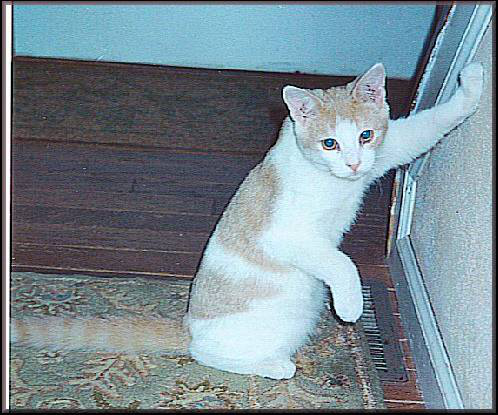

(415, 498, 3)

In [14]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
display(img_loaded)

#Get shape of image file
img_data = img_to_array(img_loaded)
img_data.shape

In [15]:
# Saving the class names
class_names = train_ds.class_names
class_names

['cats', 'dogs']

In [16]:
# Saving a dictionary with class labels:names
class_dict = dict(zip(range(len(class_names)), class_names))
class_dict

{0: 'cats', 1: 'dogs'}

Next, inspect batch shape

In [18]:
# Taking a sample banch to see batch shape
example_batch_imgs,example_batch_y= train_ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 64, 64, 3])

Next, check the format of our y data.

In [19]:
# Checking shape of a single y
display(example_batch_y[0])
print(example_batch_y[0].shape)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

(2,)


And it is always good to check an image as well.

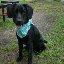

In [20]:
# Preview an image from the Dataset
array_to_img(example_batch_imgs[0])

We also need out image shape.

In [21]:
# individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([64, 64, 3])

Now, we are ready to start modeling. We will start with a baseline model using the following:

### Model 1: Baseline Model

- Start with a small network:
    - 2 pairs of Conv/Pool layers with the same params:
        - Conv2D layers:
            - filters=16
            - kernel_sizee=3
            - paddiing='same'
        - MaxPooling layers:
            - pool_size=2
            - strides=1
        - Flattening
        - Dense (final)
            - units=2
            - activation='softmax'
        - Compile
            - Optimizer='adam'
            - loss = BinaryCrossentropy() (because there are two classes, cat and dog)

Wrap the build and compile steps into a function.

In [22]:
def build_model1():
    
    model = models.Sequential(name="Model1")
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer #1
    model.add( layers.Conv2D(filters=16,  kernel_size=3, padding='same') ) 
    # Pooling layer #1
    model.add( layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Convolutional layer #2
    model.add( layers.Conv2D(filters=16, kernel_size=3, padding='same')) 
    # Pooling layer #2
    model.add(layers.MaxPooling2D(pool_size=2, strides=1))
    
    # Flattening layer
    model.add(layers.Flatten())
    # # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")
    )
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    model.summary()
    return model

Build the model and use cisualkeras to see the overall architecture.

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0    

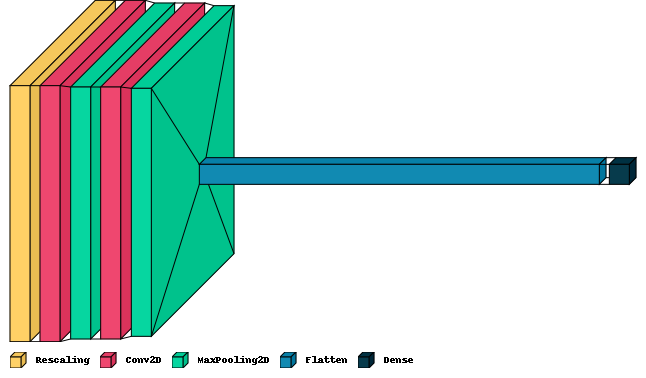

In [23]:
# Build model and visualize
model1 = build_model1()
vk.layered_view(model1, legend=True)

We will use the EarlyStopping callback with a patience of 3, set to monitor the validation accuracy, with restore_best_weights=True. By writing a simple get_callbacks() function, we can get a new early_stopping object for each model.

In [24]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Now, we will call the build function and fit our model, including our early stopping callback.

In [25]:
# Build new model and fit 
model1 = build_model1()
history = model1.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 63, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0    

We will now call the evaluation function we created in the "Flexible Evaluation Functions" lesson.

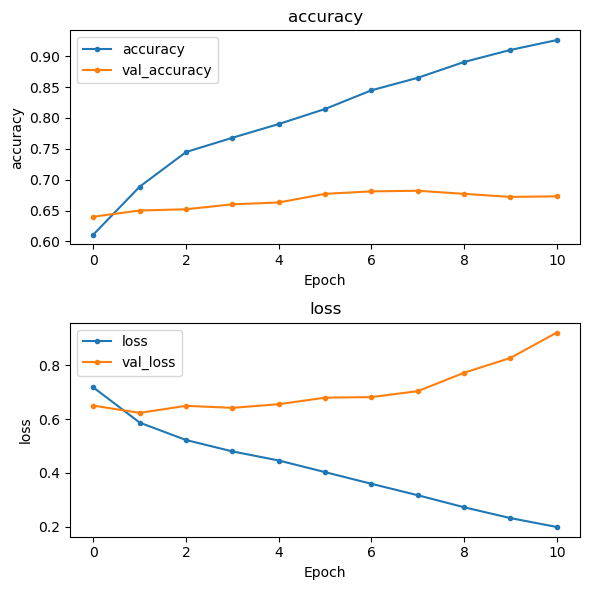


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4000
           1       0.99      0.89      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000



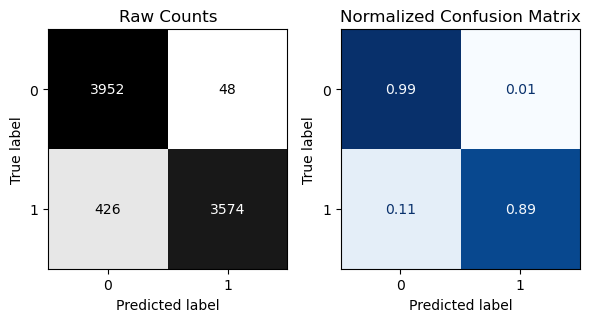


- Evaluating Training Data:
250/250 [==============================] - 5s 18ms/step - loss: 0.1619 - accuracy: 0.9408
{'loss': 0.1619168072938919, 'accuracy': 0.940750002861023}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       506
           1       0.71      0.61      0.66       494

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.68      1000
weighted avg       0.69      0.69      0.68      1000



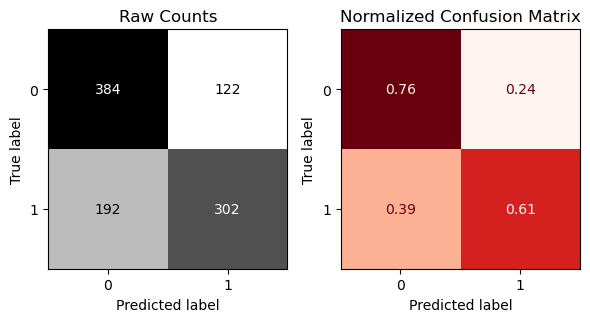


- Evaluating Test Data:
32/32 [==============================] - 1s 17ms/step - loss: 0.8417 - accuracy: 0.6860
{'loss': 0.841683030128479, 'accuracy': 0.6859999895095825}


In [27]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model1, X_train=train_ds, X_test=test_ds, history=history);

Our baseline model had a .94 training accuracy but only a .67 test accuracy. Let's see if we can improve upon this!

### Iterating on our Model

Note that there are many different approaches to tuning a CNN. Before we dive into tuning the Convolutional layers, let's first add a hidden dense layer that can analyze the output of our convolutional layers before sending their output to the final layer.

**Adding a Hidden Dense Layer**

In [28]:
def build_model_dense():
    model = models.Sequential(name='Model2')
    model.add(layers.Rescaling(1. / 255, input_shape=input_shape))
    # Conv2d/MaxPooling #1
    model.add(layers.Conv2D(16, kernel_size=3, padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    # Conv2d/MaxPooling #2
    model.add(layers.Conv2D(16, kernel_size=3,padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    model.add(layers.Flatten())
    ## NEW Hidden Dense layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"]
    )
    return model

Now, we will build, display, and fit our updated model.

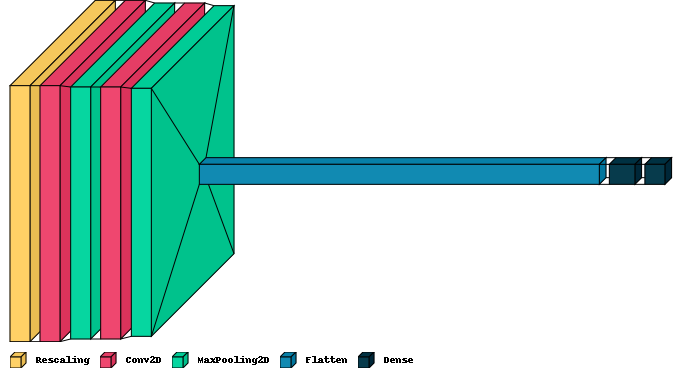

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 63, 63, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 61504)             0    

In [29]:
model2 = build_model_dense()
display(vk.layered_view(model2, legend=True))
model2.summary()
# fit the neural network
history = model2.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)

Again, we will call our custom function to see how our updates affected our evaluation.

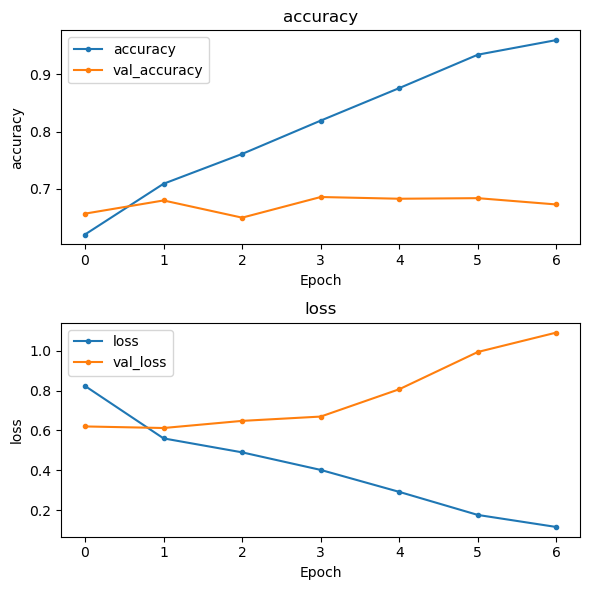


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4000
           1       0.96      0.97      0.97      4000

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



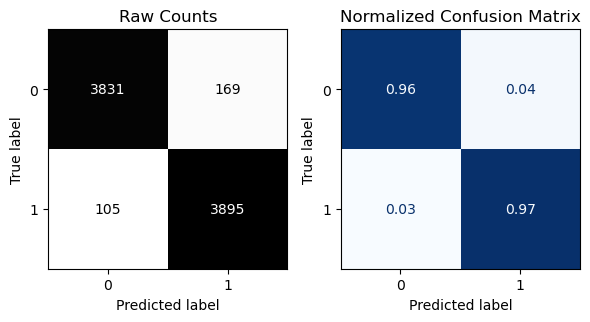


- Evaluating Training Data:
250/250 [==============================] - 6s 24ms/step - loss: 0.0967 - accuracy: 0.9657
{'loss': 0.09674444049596786, 'accuracy': 0.965749979019165}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       506
           1       0.68      0.74      0.71       494

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



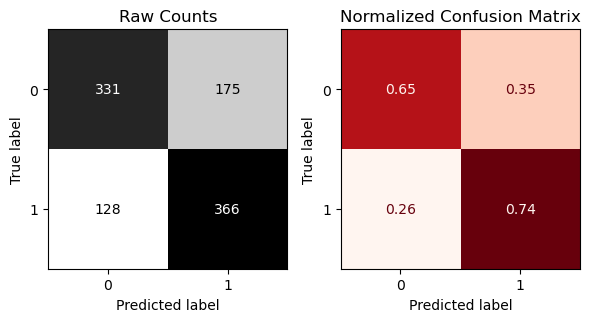


- Evaluating Test Data:
32/32 [==============================] - 1s 22ms/step - loss: 0.9984 - accuracy: 0.6970
{'loss': 0.9983553290367126, 'accuracy': 0.6970000267028809}


In [30]:
evaluate_classification_network(
    model2, X_train=train_ds,  X_test=test_ds, history=history);

By adding a hidden Dense layer, we improved our test accuracy to .73! Our training accuracy is 1.0, indicating we have overfit the model, which we will address shortly.

To tune our model more efficiently, we will now pivot to using Keras Tuner.

### Tuning a CNN Model with KerasTuner

We will tune:

- The number of filters in the first Conv2D layer:
    - Integer from 16-64, step=16
- The kernel_size of the first layer
    - A choice between 3 and 5
- The strides for the pooling layer
    - A choice between 1 and 2
- The number of convolutional blocks
    - Made of one Conv2D layer and one MaxPooling2D layer
    - Integer from 1 to 3
- The dropout_rate for the Dropout between the hidden Dense layer and the final layer 

In [31]:
def build_tune_model_deep(hp):
    model = models.Sequential()
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))
    # Setting hp params and saving as var so they can be used at >1 layer
    n_filters = hp.Int('filters_1',min_value=16, max_value=64, step=16)
    pool_strides = hp.Choice('pool_strides',[1,2])
    
    model.add(layers.Conv2D(n_filters,
                            # Test using larger kernel size (in first Conv layer ONLY)
                            kernel_size= hp.Choice('kernel_size_1',[3,5]),
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))
    for i in range(hp.Int('n_conv_layers',min_value=1, max_value=3)):
        # Double the number of filters vs. previous layer
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))
        
        # model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1, max_value=0.5, step=.1)))
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(hp.Float('dropout_rate_dense',min_value=0, max_value=0.5,
                                     step=.1)))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"],
    )
    return model

Now we will define the tuner.

In [32]:
# Define the tuner
tuner_hb = kt.Hyperband(build_tune_model_deep, objective='val_accuracy',
                        max_epochs=15, overwrite=True, seed=321,) 
# Preivew search summary
tuner_hb.search_space_summary()

Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
pool_strides (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
n_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate_dense (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


Now, we will start our search. We will also show our entire results summary so you can see how the various combinations of values performed. 

**Note that this can take a very long time to run (over an hour).**

In [ ]:
"""
# Start search
tuner_hb.search(train_ds, validation_data=val_ds, epochs=25)
# Obtain summary of results
tuner_hb.results_summary()
"""

Now, we will obtain the best-performing values for our hyperparameters and define our best_model. We will then call our custom evaluation function to see how the tuned model performs.

In [ ]:
# Print the results for beset paramters
print(f"Best Params: \n {tuner_hb.get_best_hyperparameters()[0].values}" )
# Define the best model
best_model = tuner_hb.get_best_models()[0]
# Evalute the best model with the custom evaluation function
evaluate_classification_network(best_model, X_train=train_ds, X_test=test_ds);

We see that our tuned model had an accuracy of 79%.

### Summary

Tuning neural networks can be difficult for computer vision tasks. In an upcoming lesson, we will learn how to leverage pre-trained models as base for our own neural networks, which will dramatically improve the models' performance.